# Grad-CAM: Gradient-weighted Class Activation Mapping

Classic method for visualizing CNN predictions using class-discriminative localization maps.

## Overview

Grad-CAM uses gradients flowing into the final conv layer to create a localization map showing important regions for prediction.

### Advantages:
- Fast (single forward-backward pass)
- Class-discriminative
- Works with any CNN
- Interpretable visual explanations

### Limitations:
- Coarse resolution (limited by feature map size)
- May not always reflect true attributions
- Only captures local behavior

In [10]:
# Import required libraries
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Grad-CAM Implementation

### Algorithm:

1. Forward pass: Get activations $A^k$ from target layer
2. Backward pass: Compute gradients $\frac{\partial y^c}{\partial A^k}$
3. Global average pooling: $\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A_{ij}^k}$
4. Weighted combination: $L_{Grad-CAM}^c = ReLU\left(\sum_k \alpha_k^c A^k\right)$

where $\alpha_k^c$ is the importance of feature map $k$ for class $c$.

In [11]:
class GradCAM:
    # Grad-CAM implementation
    # Reference: Selvaraju et al., ICCV 2017
    
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()
    
    def _register_hooks(self):
        # register hooks to capture gradients and activations
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)
    
    def generate_cam(
        self,
        image: torch.Tensor,
        target_class: Optional[int] = None
    ) -> np.ndarray:
        # generate Grad-CAM visualization
        self.model.eval()
        image.requires_grad = True
        
        # forward pass
        output = self.model(image)
        
        # get predicted class if not specified
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # zero gradients
        self.model.zero_grad()
        
        # backward pass
        target_score = output[0, target_class]
        target_score.backward()
        
        # compute weights (global average pooling of gradients)
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # weighted combination of activation maps
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        
        # apply ReLU (only positive influence)
        cam = torch.relu(cam)
        
        # normalize to [0, 1]
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
        
        return cam
    
    def visualize(
        self,
        image: torch.Tensor,
        cam: np.ndarray,
        alpha: float = 0.5
    ) -> np.ndarray:
        # overlay CAM on original image
        img = image.squeeze().detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        
        # denormalize (ImageNet stats)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        # resize CAM to image size
        h, w = img.shape[:2]
        cam_resized = cv2.resize(cam, (w, h)).copy()
        
        # apply colormap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = heatmap / 255.0
        
        # overlay
        overlayed = alpha * heatmap + (1 - alpha) * img
        overlayed = np.clip(overlayed, 0, 1)
        
        return overlayed

print("✓ GradCAM class defined successfully")

✓ GradCAM class defined successfully


## Load Pre-trained Model

In [12]:
# Load ResNet-50
print("Loading ResNet-50...")
model = models.resnet50(weights='IMAGENET1K_V1')
model.eval()

# Target layer (last convolutional layer)
target_layer = model.layer4[-1]

print(f"✓ Model loaded: ResNet-50")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Target layer: layer4[-1] (final residual block)")

Loading ResNet-50...
✓ Model loaded: ResNet-50
  Total parameters: 25,557,032
  Target layer: layer4[-1] (final residual block)


## Initialize Grad-CAM

In [13]:
# Initialize Grad-CAM
gradcam = GradCAM(model=model, target_layer=target_layer)
print("✓ Grad-CAM initialized")

✓ Grad-CAM initialized


## Load and Preprocess Test Image

In [14]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load sample image
data_dir = Path('input_images')
image_files = list(data_dir.glob('*.jpg')) + list(data_dir.glob('*.png'))

if len(image_files) == 0:
    print("No images found. Please run: 1_create_dataset.ipynb")
else:
    # Load first image
    image_path = image_files[0]
    image_pil = Image.open(image_path).convert('RGB')
    image_tensor = transform(image_pil).unsqueeze(0)
    
    print(f"Loaded image: {image_path.name}")
    print(f"Image size: {image_pil.size}")
    print(f"Tensor shape: {image_tensor.shape}")

Loaded image: real_012_dog.jpg
Image size: (224, 224)
Tensor shape: torch.Size([1, 3, 224, 224])


## Generate Grad-CAM Visualization

In [15]:
# Generate CAM
cam = gradcam.generate_cam(image_tensor)

# Get prediction
with torch.no_grad():
    output = model(image_tensor)
    pred_class = output.argmax(dim=1).item()
    confidence = torch.softmax(output, dim=1)[0, pred_class].item()

print(f"Generated Grad-CAM")
print(f"Predicted class: {pred_class}")
print(f"Confidence: {confidence:.4f}")
print(f"CAM shape: {cam.shape}")

Generated Grad-CAM
Predicted class: 152
Confidence: 0.9422
CAM shape: (7, 7)


## Visualize Results

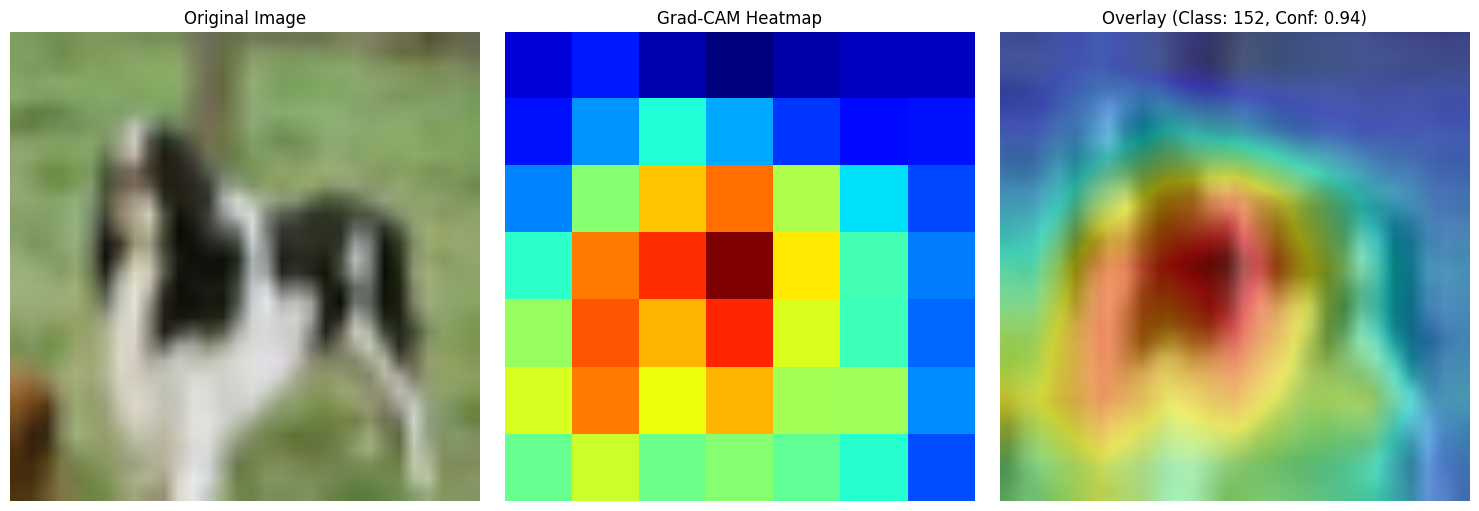


Visualization complete


In [16]:
# Create visualization
overlay = gradcam.visualize(image_tensor, cam, alpha=0.5)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(image_pil)
axes[0].set_title('Original Image', fontsize=12)
axes[0].axis('off')

# Heatmap only
axes[1].imshow(cam, cmap='jet')
axes[1].set_title('Grad-CAM Heatmap', fontsize=12)
axes[1].axis('off')

# Overlay
axes[2].imshow(overlay)
axes[2].set_title(f'Overlay (Class: {pred_class}, Conf: {confidence:.2f})', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\nVisualization complete")

## Process Multiple Images

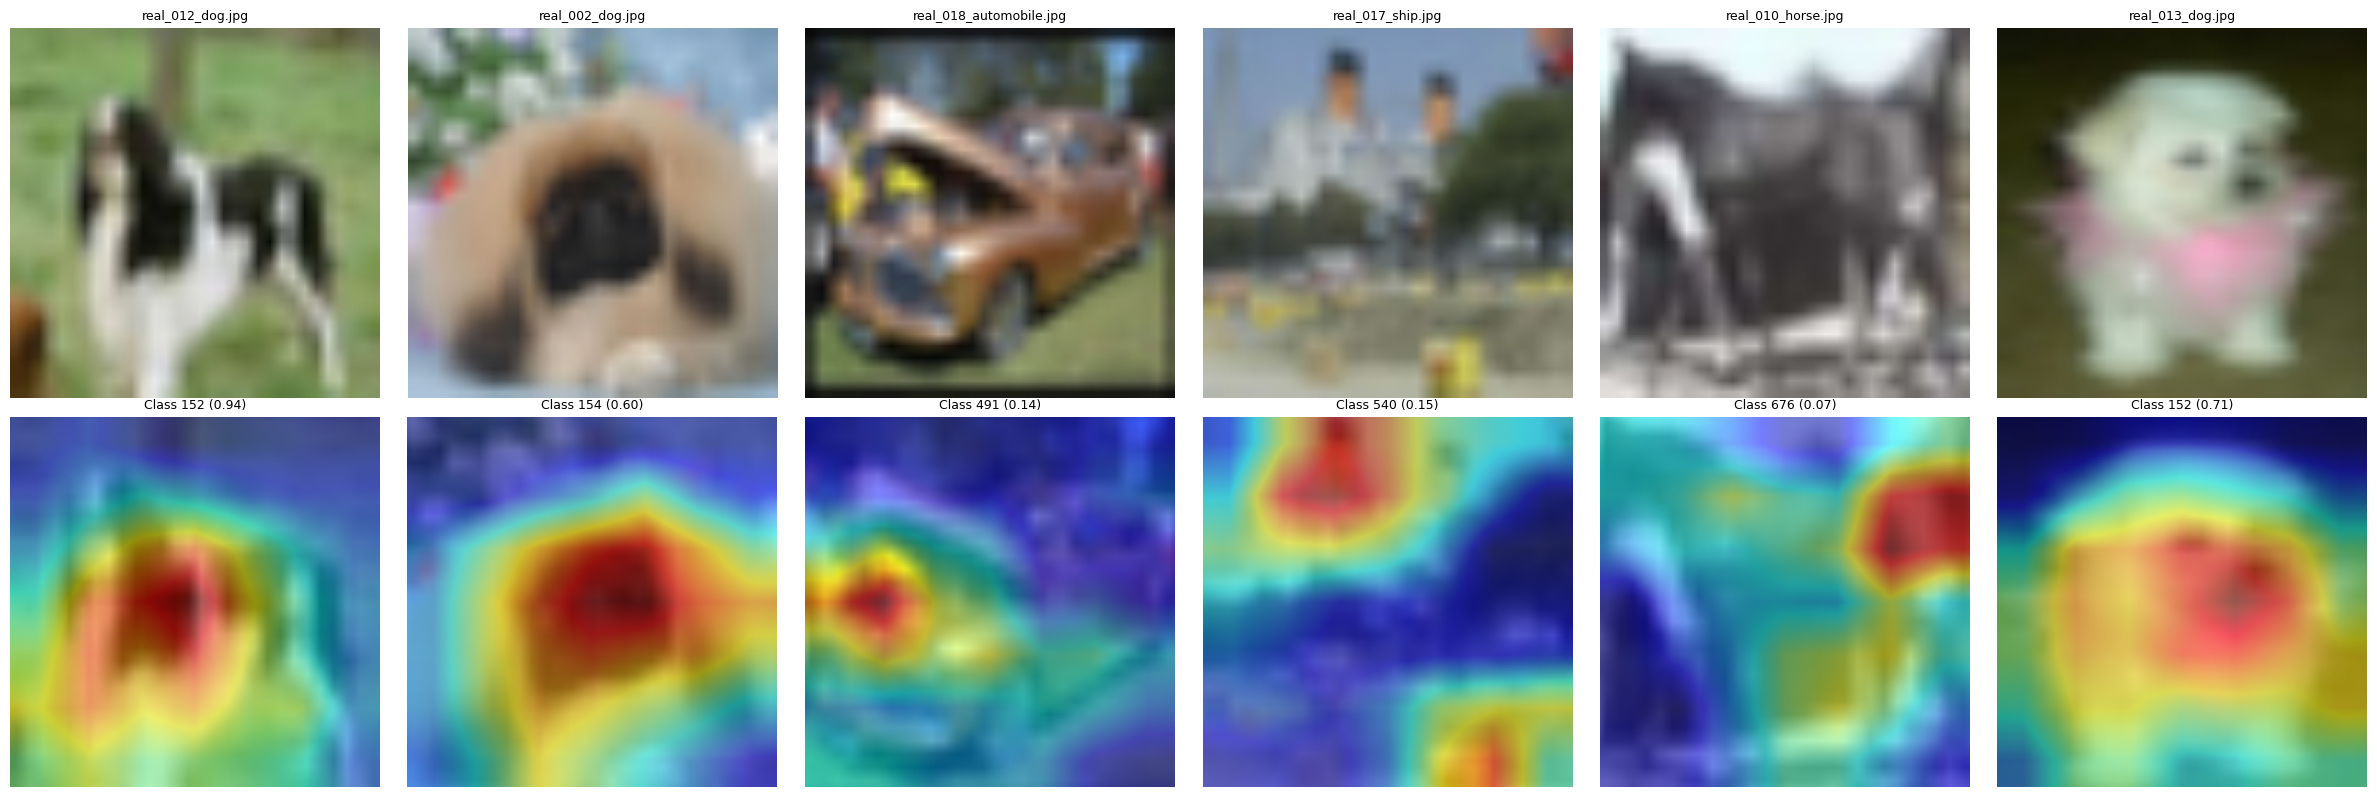


Processed 6 images


In [17]:
# Process first 6 images
num_images = min(6, len(image_files))

fig, axes = plt.subplots(2, num_images, figsize=(4*num_images, 8))
if num_images == 1:
    axes = axes.reshape(-1, 1)

for idx in range(num_images):
    # Load image
    img_pil = Image.open(image_files[idx]).convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0)
    
    # Generate CAM
    cam = gradcam.generate_cam(img_tensor)
    overlay = gradcam.visualize(img_tensor, cam, alpha=0.5)
    
    # Get prediction
    with torch.no_grad():
        output = model(img_tensor)
        pred_class = output.argmax(dim=1).item()
        conf = torch.softmax(output, dim=1)[0, pred_class].item()
    
    # Plot original
    axes[0, idx].imshow(img_pil)
    axes[0, idx].set_title(f'{image_files[idx].name}', fontsize=9)
    axes[0, idx].axis('off')
    
    # Plot overlay
    axes[1, idx].imshow(overlay)
    axes[1, idx].set_title(f'Class {pred_class} ({conf:.2f})', fontsize=9)
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\nProcessed {num_images} images")

## Save Sample Results

In [18]:
# Create output directory
output_dir = Path('results/gradcam_examples')
output_dir.mkdir(parents=True, exist_ok=True)

# Save first image results
image_pil = Image.open(image_files[0]).convert('RGB')
image_tensor = transform(image_pil).unsqueeze(0)
cam = gradcam.generate_cam(image_tensor)
overlay = gradcam.visualize(image_tensor, cam, alpha=0.5)

# Save overlay
plt.imsave(output_dir / 'gradcam_overlay.png', overlay)
plt.imsave(output_dir / 'gradcam_heatmap.png', cam, cmap='jet')

print(f"Saved results to: {output_dir}")
print(f"  gradcam_overlay.png")
print(f"  gradcam_heatmap.png")

Saved results to: results/gradcam_examples
  gradcam_overlay.png
  gradcam_heatmap.png


---

## Paper Citation

**Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization**

Selvaraju et al., ICCV 2017

Paper: https://arxiv.org/abs/1610.02391

**Main contributions:**
- Class-discriminative localization without architecture changes
- Works with any CNN
- Visual debugging for deep models
- Foundation for many XAI methods

---

## Next Steps

Run the next notebook: **3_layercam.ipynb**